In [7]:
import pandas as pd
import numpy as np

from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split


In [2]:
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)  # does not contain targets

#Gender
train_no_gender = train.copy().drop(columns="Gender")
test_no_gedner = test.copy().drop(columns="Gender")

# Married
train_no_nan_married = train_no_gender.copy().dropna(axis=0, subset=["Married"])
train_no_nan_married = pd.get_dummies(train_no_nan_married, columns=["Married"], drop_first=True)

# Dependents
train_dependent_only_int = train_no_nan_married.copy().replace("3+", 3)
for number in range(0, 3):
    train_dependent_only_int = train_dependent_only_int.replace(f"{number}", number)

train_dependents_no_nan = train_dependent_only_int.copy()


# Education
train_education_dummies = pd.get_dummies(train_dependents_no_nan.copy(), columns=["Education"], drop_first=True)

train_self_employed_encoded = train_education_dummies.copy()

# Self_Employed

train_self_employed_encoded.Self_Employed = train_self_employed_encoded.Self_Employed.replace(["No", "Yes"], [0, 1]) 

# Loan_Amount_Term
si = SimpleImputer(strategy="median")

train_imputed_loan_amount_term = train_self_employed_encoded.copy()
train_imputed_loan_amount_term.Loan_Amount_Term = si.fit_transform(train_imputed_loan_amount_term.Loan_Amount_Term.values.reshape(-1, 1))

# Credit_History



# Property_Area and Loan_Status
train_property_area_n_target = pd.get_dummies(train_imputed_loan_amount_term.copy(), columns=["Property_Area", "Loan_Status"], drop_first=True)

# Loan amount
train_LoanAmount_itterative_imputer = train_property_area_n_target.copy()

X = train_LoanAmount_itterative_imputer.iloc[:, :-1]
y = train_LoanAmount_itterative_imputer.iloc[:, -1]

imp_mean = IterativeImputer(random_state=0)
X = imp_mean.fit_transform(X)

X = pd.DataFrame(X, columns=train_LoanAmount_itterative_imputer.iloc[:, :-1].columns)

In [6]:
X.isnull().sum()

Dependents                 0
Self_Employed              0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Married_Yes                0
Education_Not Graduate     0
Property_Area_Semiurban    0
Property_Area_Urban        0
dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe_forest = make_pipeline(
    StandardScaler(),  # need to scale before usage of PCA
    PCA(),
    RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=1000)
)

param_range  = np.arange(2, 10, 1) # For max_depth

param_range2 = np.arange(2, 3, 1) # for min_samples_split

param_range3 = np.arange(1, 2, 1) # for min_samples_leaf

param_grid   = [
    {'randomforestclassifier__max_depth': param_range, 
     'pca__n_components': [3, 4, 5, 6, 7],
     #'randomforestclassifier__min_samples_split': param_range2,
     #'randomforestclassifier__min_samples_leaf': param_range3,
     #'randomforestclassifier__oob_score': [True, False],
     'randomforestclassifier__criterion': ['gini', 'entropy']
    }
]


gs = GridSearchCV(estimator=pipe_forest, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5,  # fewer cross-validations to reduce time usage
                  n_jobs=-1)

In [22]:
%%time
gs = gs.fit(X_train, y_train)

Wall time: 4min 39s


In [23]:
print(gs.best_score_)
print(gs.best_params_)

0.8081532147742818
{'pca__n_components': 7, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2}


In [24]:
for r, _ in enumerate(gs.cv_results_['mean_test_score']):
    print("%0.4f +/- %0.4f %r"
          % (gs.cv_results_['mean_test_score'][r],
             gs.cv_results_['std_test_score'][r],
             gs.cv_results_['params'][r]))

0.6862 +/- 0.0043 {'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2}
0.6792 +/- 0.0057 {'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 3}
0.6768 +/- 0.0115 {'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 4}
0.6839 +/- 0.0123 {'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 5}
0.6581 +/- 0.0160 {'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 6}
0.6557 +/- 0.0186 {'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 7}
0.6486 +/- 0.0162 {'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8}
0.6322 +/- 0.0210 {'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestcla

In [25]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")  # Looking at how the model preformed against the test set

Test accuracy: 0.788


In [26]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Permute
result = permutation_importance(clf, X_test, y_test, n_repeats=100, random_state=0)



NameError: name 'plt' is not defined

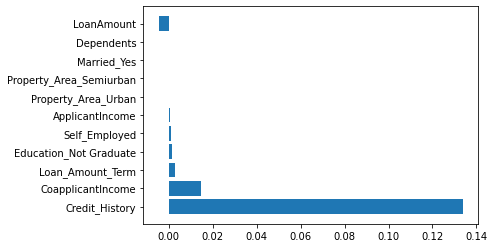

In [28]:
import matplotlib.pyplot as plt
# Plot importances
ind = indices = np.argsort(result.importances_mean)[::-1]
plt.barh(X.columns[ind], result.importances_mean[ind])
plt.show()

In [36]:
X

,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Married_Yes,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban
0,0.0,0.0,5849.0,0.0,138.028459,360.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,4583.0,1508.0,128.000000,360.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,3000.0,0.0,66.000000,360.0,1.0,1.0,0.0,0.0,1.0
3,0.0,0.0,2583.0,2358.0,120.000000,360.0,1.0,1.0,1.0,0.0,1.0
4,0.0,0.0,6000.0,0.0,141.000000,360.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,2900.0,0.0,71.000000,360.0,1.0,0.0,0.0,0.0,0.0
607,3.0,0.0,4106.0,0.0,40.000000,180.0,1.0,1.0,0.0,0.0,0.0
608,1.0,0.0,8072.0,240.0,253.000000,360.0,1.0,1.0,0.0,0.0,1.0
609,2.0,0.0,7583.0,0.0,187.000000,360.0,1.0,1.0,0.0,0.0,1.0


In [43]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

pipe_forest = make_pipeline(
    StandardScaler(),  # need to scale before usage of PCA
    PCA(n_components=7),
    RandomForestClassifier(criterion="gini", max_depth=2, random_state=1, n_jobs=-1, n_estimators=1000)
)

# Prepare SFS
sfs = SFS(pipe_forest, 
          k_features=(2, 5), 
          forward=True,   # Change to False to get backwards selection
          floating=False, 
          scoring='accuracy',
          cv=5)

# Fit'n plot
sfs = sfs.fit(X_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

C:\Users\eirik\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\eirik\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\eirik\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\eirik\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\eirik\Anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\eirik\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

KeyError: None

In [42]:
y_train.isnull().sum()

0

In [45]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# Prepare EFS
efs = EFS(pipe_forest, 
          min_features=9, # <--- Careful
          max_features=11, # <--- Careful
          scoring='accuracy',
          cv=10)

# Fit
efs.fit(X_train, y_train)

print('Best R2 score: %.2f' % efs.best_score_)
print('Best subset (indices):', efs.best_idx_)
print('Best subset (corresponding names):', efs.best_feature_names_)

Features: 67/67

Best R2 score: 0.82
Best subset (indices): (0, 2, 3, 4, 5, 6, 8, 9, 10)
Best subset (corresponding names): ('Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Education_Not Graduate', 'Property_Area_Semiurban', 'Property_Area_Urban')
